# AR Baseline — Volume Prediction

Denne notatboken etablerer en **baseline** med rene **AR(p)**-modeller (uten eksogene variabler) for å predikere markedsvolum.
Vi bruker `log_volume` som mål (for stabil varians), estimerer AR(p), og evaluerer prognoser i **nivå** etter tilbakeføring.



In [1]:
# --- Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


In [2]:
# --- Helper functions
def residual_diagnostics(resid, lags=24):
    r = pd.Series(resid).dropna()
    lb = acorr_ljungbox(r, lags=[lags], return_df=True)
    return {
        "eps_mean": float(r.mean()),
        "eps_std": float(r.std(ddof=1)),
        f"LjungBox_p(lag{lags})": float(lb["lb_pvalue"].iloc[-1]),
    }

def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)

def adf_p(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1]


## Data

In [3]:
# --- Load prepared train/test CSVs. Must have columns: date, volume_all (and optionally others)
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Create log volume
train['log_volume'] = np.log(train['volume_all'])
test['log_volume']  = np.log(test['volume_all'])

V_tr = train['log_volume']
V_te = test['log_volume']

print('ADF p (train log_volume):', adf_p(V_tr))


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723
ADF p (train log_volume): 0.021968939716481256


## AR(p) baseline — grid search and evaluation

In [4]:
# Configure p grid here
p_list = [1,2,3,4,5]

rows = []
models = {}
forecasts_level = {}

y_te_level = np.exp(V_te)

for p in p_list:
    mdl = sm.tsa.SARIMAX(
        V_tr, order=(p,0,0), trend='c',
        enforce_stationarity=True, enforce_invertibility=False
    ).fit(disp=False)
    
    fc = mdl.get_forecast(steps=len(V_te))
    sf = fc.summary_frame()
    mu = sf['mean']
    sigma2 = sf['mean_se']**2
    pred_level = np.exp(mu + 0.5*sigma2)  # bias-corrected back-transform to level
    
    mse  = float(np.mean((y_te_level - pred_level)**2))
    mae_ = float(np.mean(np.abs(y_te_level - pred_level)))
    mape_= float(np.nanmean(np.abs((y_te_level - pred_level)/y_te_level))*100)
    diag = residual_diagnostics(mdl.resid, lags=24)
    
    rows.append({
        "model": f"AR({p})",
        "p": p,
        "AIC": float(mdl.aic),
        "MSE(level)": mse,
        "MAE(level)": mae_,
        "MAPE(level)": mape_,
        "LB_p(lag24)": diag["LjungBox_p(lag24)"]
    })
    models[p] = mdl
    forecasts_level[p] = pred_level

results = pd.DataFrame(rows).sort_values("AIC").reset_index(drop=True)
results


/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfuglerudflugstad/miniconda3/envs/finance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/fredrikfugler

,model,p,AIC,MSE(level),MAE(level),MAPE(level),LB_p(lag24)
0,AR(5),5,-4776.666089,1.971686e+19,4.016864e+09,37.746531,3.900922e-18
1,AR(4),4,-4693.777723,1.974355e+19,4.022051e+09,37.805504,1.956590e-26
2,AR(3),3,-4578.752836,1.976754e+19,4.026764e+09,37.858716,2.004117e-44
3,AR(2),2,-4496.885937,1.979348e+19,4.031075e+09,37.905637,5.612680e-57
4,AR(1),1,-4253.327692,1.980298e+19,4.033767e+09,37.937275,5.475849e-85


## Best model diagnostics & plot

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4329      0.153      9.337      0.000       1.132       1.734
ar.L1          0.6125      0.009     71.176      0.000       0.596       0.629
ar.L2          0.1076      0.014      7.641      0.000       0.080       0.135
ar.L3          0.0155      0.015      1.071      0.284      -0.013       0.044
ar.L4          0.0704      0.014      5.126      0.000       0.043       0.097
ar.L5          0.1302      0.012     10.571      0.000       0.106       0.154
sigma2         0.0223      0.000    104.844      0.000       0.022       0.023

Residual diagnostics: {'eps_mean': 0.0002534683371546021, 'eps_std': 0.1494186177497141, 'LjungBox_p(lag24)': 3.900921580152148e-18}


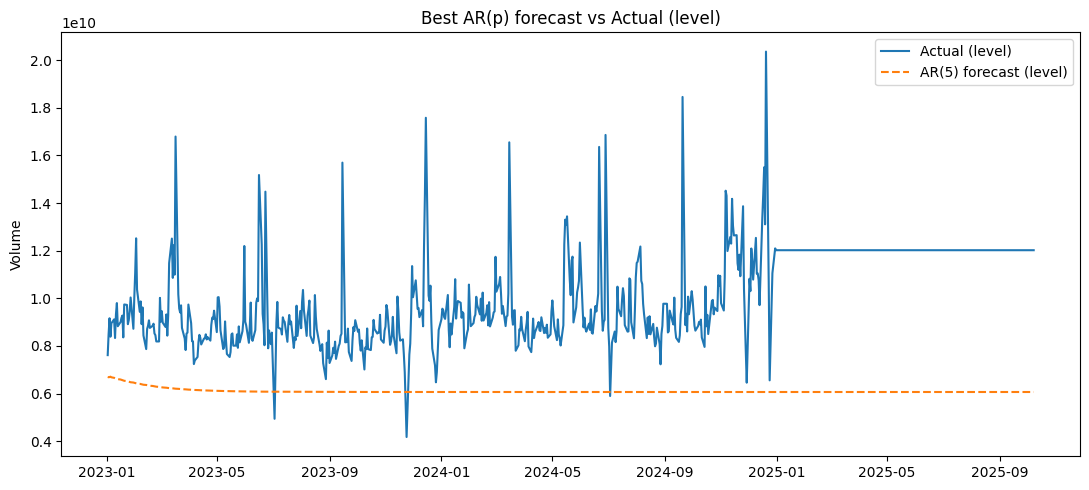

In [5]:
best_p = int(results.loc[results['AIC'].idxmin(), 'p'])
best_model = models[best_p]
best_pred_level = forecasts_level[best_p]

print(best_model.summary().tables[1])
print("\nResidual diagnostics:", residual_diagnostics(best_model.resid, lags=24))

plt.figure(figsize=(11,5))
plt.plot(V_te.index, y_te_level.values, label="Actual (level)")
plt.plot(V_te.index, best_pred_level.values, label=f"AR({best_p}) forecast (level)", linestyle="--")
plt.title("Best AR(p) forecast vs Actual (level)")
plt.ylabel("Volume"); plt.legend(); plt.tight_layout(); plt.show()



> **Merk:** Vi estimerer AR på `log_volume` for stabil varians, men evaluerer prognoser i **nivå** etter bias-korrigert tilbakeføring.
> Neste steg i prosjektet blir å legge til **eksogene** (VIX/RV) i en ARX/ARIMAX-notatbok for å teste informasjonsverdi.
